In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gp


pd.set_option('display.max_columns', None)

## Load traffic data

In [59]:
#Change the dataset to be read in once new road boundary apportionment takes place.
cotraffic = pd.read_csv('Transportation/tractTraffic_June1/5_output/NV-NM-CO_VMT.csv')
cotraffic.columns = [column.replace('VMT_','DVMT_') for column in cotraffic]
cotraffic.drop(columns ='Unnamed: 0', inplace=True)
cotraffic = cotraffic[cotraffic['STATE'] == 'Colorado']
cotraffic.drop(columns ='STATE', inplace=True)
cotraffic.set_index('GEOID',inplace=True)
cotraffic.drop(columns = cotraffic.columns[~cotraffic.columns.str.contains('ex')], inplace=True)
cotraffic.columns = [column.replace('_ex','') for column in cotraffic]

In [60]:
traffic_breakdown = pd.DataFrame()
for i in cotraffic.columns:
    traffic_breakdown[str(i)] = cotraffic[str(i)]
    traffic_breakdown[str(i)+'_pct'] = cotraffic[str(i)]/cotraffic.sum(axis=1)
all_dvmt_inds = traffic_breakdown.columns.str.contains('pct') == False
traffic_breakdown['DVMT_all'] = traffic_breakdown.loc[:,all_dvmt_inds].sum(axis=1)
sucu_inds = traffic_breakdown.columns.str.contains('combo')| traffic_breakdown.columns.str.contains('sing') & ~traffic_breakdown.columns.str.contains('pct')
traffic_breakdown['DVMT_SUCU'] = traffic_breakdown.loc[:,sucu_inds].sum(axis=1)
traffic_breakdown['DVMT_SUCU_pct'] = traffic_breakdown['DVMT_SUCU']/traffic_breakdown['DVMT_all'] 

In [61]:
#This ratio is based on statewide VMT split between LDV and LDT sent by Dale Wells from CDPHE.
ldv_frac = .5 #light duty vehicle fraction of DVMT_light (the rest is attributed to light duty trucks)

cotraffic['DVMT_light_vehicles'] = cotraffic['DVMT_light']*ldv_frac
cotraffic['DVMT_light_trucks'] = cotraffic['DVMT_light']*(1-ldv_frac)
cotraffic.drop(columns='DVMT_light', inplace=True)

## Load emission factors and convert to CO vehicle types

In [62]:
emissionfactors = pd.read_csv('Transportation/USDOT_BTS_USAvgMobileSourceEmissionFactors_HCcoNOXpm25_byVehicleType_April2020.csv')
emissionfactors['Vehicle Type'] = emissionfactors['Vehicle Type']+'_'+emissionfactors['Fuel Type']
emissionfactors.drop(columns='Fuel Type', inplace=True)

emissionfactors = emissionfactors.pivot(index = 'Vehicle Type', columns = 'pollutant', values = 'emissions (grams/mile)')
emissionfactors['PM2.5'] = emissionfactors[emissionfactors.columns[emissionfactors.columns.str.contains('PM2.5')]].sum(axis=1)    
emissionfactors.drop(columns=['Brakewear PM2.5','Tirewear PM2.5', 'Exhaust PM2.5'],inplace=True)
emissionfactors.columns = [column.replace('Total ','') for column in emissionfactors]
emissionfactors.columns = [column.replace('Exhaust ','') for column in emissionfactors]
emissionfactors.columns = [column.replace('Co2','CO2') for column in emissionfactors]

emissionfactors = emissionfactors.stack().reset_index(level=1, name='emissions (grams/mile)').rename(columns={'level_1':'pollutant'})[['pollutant','emissions (grams/mile)']]
emissionfactors = emissionfactors.reset_index()


## Convert emission factors for CO vehicle types


In [63]:
mapping = {
    'DVMT_combo' : 'Heavy-duty vehicles',
    'DVMT_sing' : 'Heavy-duty vehicles',
    'DVMT_light_trucks' : 'Light-duty trucks',
    'DVMT_light_vehicles' : 'Light-duty vehicles',
}

diesel_fraction = { 'Heavy-duty vehicles': .894*1.013,
                    'Light-duty trucks':  .045*1.013, 
                    'Light-duty vehicles': .06*1.013}

In [64]:
for col in cotraffic.columns:
    vehicle_type = mapping[col]
    diesel_vmtfraction = diesel_fraction[vehicle_type]
    cotraffic[str(col)+'_'+'diesel'] = cotraffic[col] * diesel_vmtfraction
    cotraffic[str(col)+'_'+'gasoline'] = cotraffic[col] * (1-diesel_vmtfraction)
    cotraffic.drop(columns=col, inplace=True)

In [65]:
mapping = {
    'DVMT_combo_gasoline': 'Heavy-duty vehicles_gasoline',
    'DVMT_sing_gasoline': 'Heavy-duty vehicles_gasoline',
    'DVMT_light_trucks_gasoline': 'Light-duty trucks_gasoline',
    'DVMT_light_vehicles_gasoline': 'Light-duty vehicles_gasoline',
    'DVMT_combo_diesel': 'Heavy-duty vehicles_diesel',
    'DVMT_sing_diesel': 'Heavy-duty vehicles_diesel',
    'DVMT_light_trucks_diesel': 'Light-duty trucks_diesel',
    'DVMT_light_vehicles_diesel': 'Light-duty vehicles_diesel'
}

In [66]:
reduced_ef = pd.DataFrame(index=pd.unique(emissionfactors.pollutant), columns=cotraffic.columns)
for col in reduced_ef.columns:
    vehicle_type = mapping[col]
    vehicle_inds = emissionfactors['Vehicle Type'] == vehicle_type
    for pol in reduced_ef.index:
        pol_inds = emissionfactors['pollutant'] == pol
        pol_vehicles = emissionfactors[vehicle_inds & pol_inds]
        emissions = pol_vehicles['emissions (grams/mile)'].sum()
        reduced_ef.loc[pol, col] = emissions

In [67]:
tract_dailyemissions_g = cotraffic.dot(reduced_ef.T)
tract_annualemissions_tons = tract_dailyemissions_g * 365 / 1000000

In [68]:
pollutants = emissionfactors['pollutant'].unique()

In [69]:
cotraffic = cotraffic.stack().reset_index(level=1, name='DVMT').rename(columns={'level_1':'Source Type'})[['Source Type','DVMT']]
for pol in pollutants:
    cotraffic[pol] = 0
cotraffic = cotraffic.reset_index()
cotraffic = pd.melt(cotraffic,id_vars=['GEOID', 'Source Type','DVMT'], value_vars=pollutants, var_name='Pollutant Type', value_name='Emissions (g/mile)')

In [70]:
for vehicle in reduced_ef.T.index:
    for pol in reduced_ef.T.columns:
        vehicle_inds = cotraffic['Source Type'] == vehicle
        pol_inds = cotraffic['Pollutant Type'] == pol
        cotraffic.loc[vehicle_inds & pol_inds,'Emissions (g/mile)'] = reduced_ef.T.loc[vehicle,pol]
cotraffic['GEOID'] = cotraffic['GEOID'].astype(str)
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace('DVMT_','')
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace('combo','heavy_combination-unit_truck')
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace('sing','heavy_single-unit_truck')
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace('_',' ')
cotraffic.insert(loc=2, column='Fuel Type',value=cotraffic['Source Type'].str.split().str[-1])
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace(' diesel','')
cotraffic['Source Type'] = cotraffic['Source Type'].str.replace(' gasoline','')

In [71]:
cotraffic['Annual Emissions'] = cotraffic['DVMT'] * 365 * cotraffic['Emissions (g/mile)'] / 1000000
cotraffic.insert(loc=0, column='Year',value='2018')
cotraffic.insert(loc=1, column='State',value='CO')
cotraffic.insert(loc=2, column='County',value=cotraffic['GEOID'].str[1:4])
cotraffic.rename(columns={'GEOID': 'Census Tract'}, inplace=True)
cotraffic.insert(loc=4, column='Sector',value='Transportation')
cotraffic.insert(loc=6, column='Data Category',value='NP')
cotraffic.insert(loc=10, column='Fuel Amount',value='N/A')
cotraffic.insert(loc=11, column='Fuel Units',value='N/A')
cotraffic.insert(loc=12, column='Pollutant Category', value='')
cotraffic.insert(loc=15, column = 'Scenario', value = 'Reference')
#cotraffic.columns = [x.title() for x in cotraffic.columns]

In [72]:
cotraffic.drop(columns={'Emissions (g/mile)', 'DVMT'}, inplace=True)

In [73]:
for pol in cotraffic['Pollutant Type'].unique():
    pol_inds = cotraffic['Pollutant Type'] == pol
    if pol == 'CO2':
        cotraffic.loc[pol_inds,'Pollutant Category'] = 'GHG'
    else:
        cotraffic.loc[pol_inds,'Pollutant Category'] = 'CAP'

## Convert county codes to county names

In [39]:
import cenpy

In [40]:
acs = cenpy.products.ACS(2018)
co = acs.from_state('CO')
co.set_index('GEOID', inplace=True)

In [74]:
county_codes = co[['NAME','county']]
county_codes['NAME'] = county_codes['NAME'].str.split().str[3:4]
county_codes['NAME'] = county_codes['NAME'].str[0]
county_codes.rename(columns={'NAME': 'County Name', 'county': 'County'}, inplace=True)
county_codes.set_index('County',inplace=True)
county_codes = county_codes.drop_duplicates()

/Users/AnnieDillon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/AnnieDillon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/AnnieDillon/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [75]:
cotraffic['County Name'] = 0
for county in county_codes.index.unique():
    code = county_codes.loc[county]
    code_inds = cotraffic['County']==county
    cotraffic.loc[code_inds,'County Name'] = code['County Name']
cotraffic.rename(columns={'County': 'County Code'}, inplace=True)
cotraffic = cotraffic[['Year', 'State', 'County Name', 'Census Tract', 'Sector', 'Source Type',
       'Data Category', 'Fuel Type', 'Fuel Amount',
       'Fuel Units', 'Pollutant Category', 'Pollutant Type','Annual Emissions', 'Scenario',
       'County Code']]
cotraffic.drop(columns='County Code', inplace=True)
cotraffic.to_csv('Transportation/Code Outputs/co_transportationemissions_bycountysource.csv')

## Join tract-level emissions with demographic data

In [15]:
pollutants = tract_annualemissions_tons.columns

In [140]:
ejscreen = pd.read_csv('Demographic/Census Tract EJ Index Colorado.csv')
ejscreen.drop(columns = ['STATE_NAME', 'Unnamed: 0'], inplace = True)
ejscreen.set_index('TRACT', inplace = True)

In [142]:
tract_area = pd.read_csv('Demographic/2018acs5yr_tract.csv')
tract_area.drop(tract_area.columns.difference(['GEOID','tract_area']), 1, inplace=True)
tract_area.set_index('GEOID', inplace=True)

In [18]:
demographics = tract_annualemissions_tons.join(ejscreen).dropna()
demographics = demographics.join(traffic_breakdown).dropna()
demographics = demographics.join(tract_area).dropna()
demographics['pop_density_persqmi'] = demographics['Population']/demographics['tract_area']
demographics['DVMT_all_persqmi'] = demographics['DVMT_all']/demographics['tract_area']
demographics['DVMT_SUCU_persqmi'] = demographics['DVMT_SUCU']/demographics['tract_area']
demographics['DVMT_light_persqmi'] = demographics['DVMT_light']/demographics['tract_area']
demographics['DVMT_combo_persqmi'] = demographics['DVMT_combo']/demographics['tract_area']
demographics['DVMT_sing_persqmi'] = demographics['DVMT_sing']/demographics['tract_area']
demographics['DVMT_all_perpop'] = demographics['DVMT_all']/demographics['Population']

for i in pollutants:
    demographics[str(i) + '_pctile'] = demographics[str(i)].rank(pct=True)
    demographics[str(i) + '_percapita'] = demographics[str(i)]/demographics['Population']
    demographics[str(i) + '_percapita_pctile'] = demographics[str(i) + '_percapita'].rank(pct=True)
    demographics[str(i) + '_per_sqmi'] = demographics[str(i)]/demographics['tract_area']
    demographics[str(i) + '_per_sqmi_pctile'] = demographics[str(i) + '_per_sqmi'].rank(pct=True)
demographics.to_csv('Demographic/co_emissions_ejscreen.csv') 

In [20]:
metromicrorural = pd.read_csv('Demographic/NVNMCOtract_MetroMicroRural.csv')
metromicrorural.drop(metromicrorural.columns.difference(['GEOID','NAME_1','MEMI']), 1, inplace=True)
metromicrorural.set_index('GEOID', inplace=True)

In [21]:
metro_demographics = metromicrorural[metromicrorural['MEMI'] == 1]
metro_demographics = metro_demographics.join(demographics).dropna()
metro_demographics.to_csv('Demographic/co_emissions_ejscreen_metro.csv')

micro_demographics = metromicrorural[metromicrorural['MEMI'] == 2]
micro_demographics = micro_demographics.join(demographics).dropna()
micro_demographics.to_csv('Demographic/co_emissions_ejscreen_micro.csv')

rural_demographics = metromicrorural[metromicrorural['MEMI'] == 3]
rural_demographics = rural_demographics.join(demographics).dropna()
rural_demographics.to_csv('Demographic/co_emissions_ejscreen_rural.csv')

In [25]:
co.set_index(co.index.astype(int),inplace=True)
combo = co.join(tract_annualemissions_tons).dropna()
combo[pollutants] = combo[pollutants].astype(np.float)

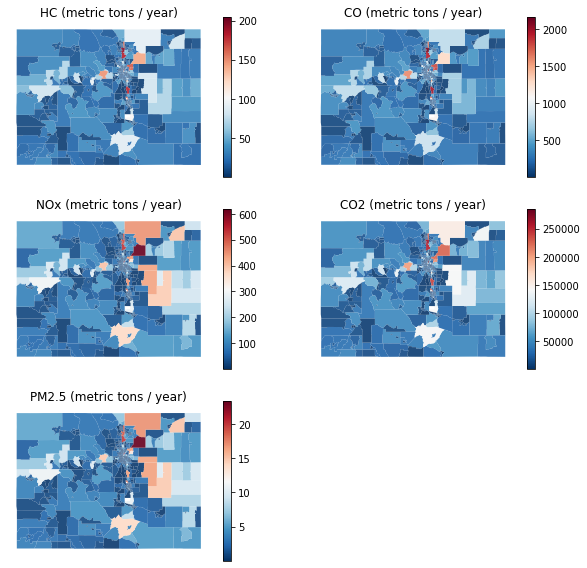

In [26]:
f,ax_array = plt.subplots(3,2, figsize=(10,10))
for i, pol in enumerate(pollutants):
    pol
    ax = np.ravel(ax_array)[i]
    combo.plot(pol, cmap='RdBu_r', ax = ax, alpha=.9, legend=True)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
ax_array[-1,-1].set_axis_off()
#plt.savefig('./figures/colorado/CO_pollutantmaps.png',dpi=400)

ax.set_facecolor('k')

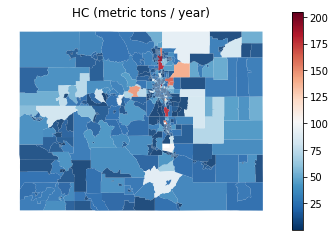

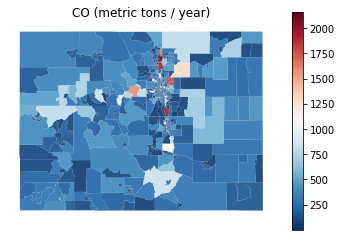

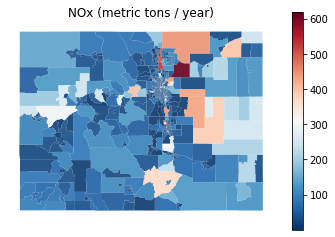

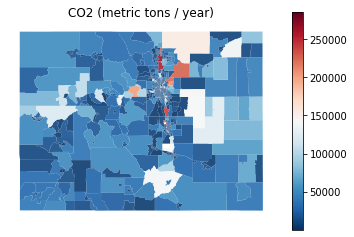

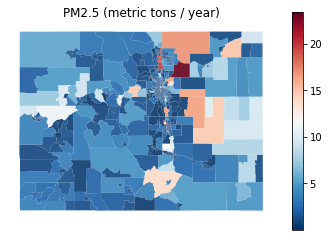

In [27]:
for i, pol in enumerate(pollutants):
#     ax = np.ravel(ax_array)[i]
    combo.plot(pol, cmap='RdBu_r', alpha=.9, legend=True)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
    #plt.savefig('./figures/colorado/{} annualtons_CO_map.png'.format(pol),dpi=400)

ax.set_facecolor('k')

In [28]:
combo_denver = combo[combo['NAME'].str.contains('Denver County') == True]
combo_denver_persqmi = combo_denver.join(tract_area).dropna()
combo_denver_persqmi[pollutants] = combo_denver_persqmi[pollutants].div(combo_denver_persqmi['tract_area'].values,axis=0)
combo_denver_persqmi.drop(columns =['tract_area'])

,geometry,NAME,state,county,tract,HC,CO,NOx,CO2,PM2.5
GEOID,,,,,,,,,,
8031011902,"POLYGON ((-11696558.420 4816649.630, -11696518...","Census Tract 119.02, Denver County, Colorado",08,031,011902,6.955529,83.425070,10.226988,8298.004745,0.364575
8031000501,"POLYGON ((-11694473.070 4830905.910, -11694447...","Census Tract 5.01, Denver County, Colorado",08,031,000501,2.608875,30.552206,4.578537,3215.973270,0.165620
8031000502,"POLYGON ((-11692923.500 4829985.280, -11692923...","Census Tract 5.02, Denver County, Colorado",08,031,000502,1.647318,19.360390,2.821809,2021.005060,0.101886
8031000102,"POLYGON ((-11694473.630 4833580.990, -11694473...","Census Tract 1.02, Denver County, Colorado",08,031,000102,6.826903,76.905543,15.040210,8842.177408,0.552346
8031015400,"POLYGON ((-11695795.880 4835370.570, -11695795...","Census Tract 154, Denver County, Colorado",08,031,015400,25.001777,282.314384,54.409858,32288.617520,1.996733
...,...,...,...,...,...,...,...,...,...,...
8031002802,"POLYGON ((-11687162.720 4824084.250, -11687161...","Census Tract 28.02, Denver County, Colorado",08,031,002802,35.679369,413.936444,66.536961,44528.844721,2.417482
8031002902,"POLYGON ((-11686374.130 4821855.130, -11686362...","Census Tract 29.02, Denver County, Colorado",08,031,002902,40.390623,448.837992,95.180611,53177.981667,3.508857
8031003603,"POLYGON ((-11684068.150 4830143.970, -11684067...","Census Tract 36.03, Denver County, Colorado",08,031,003603,11.029328,128.352167,20.171375,13709.576218,0.731873


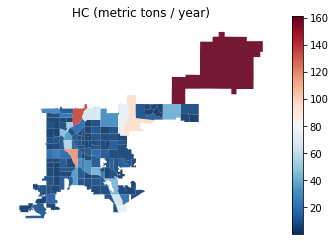

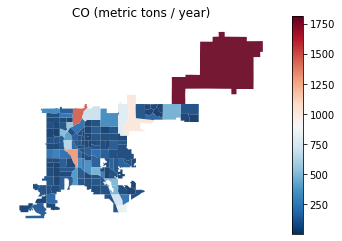

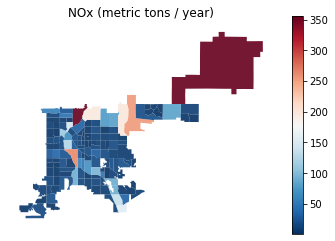

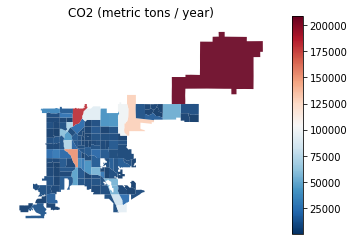

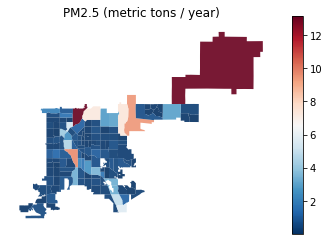

In [29]:
for i, pol in enumerate(pollutants):
#     ax = np.ravel(ax_array)[i]
    combo_denver.plot(pol, cmap='RdBu_r', alpha=.9, legend=True)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
    plt.savefig('./figures/colorado/{}_denver_annualtons_map.png'.format(pol),dpi=400)

ax.set_facecolor('k')

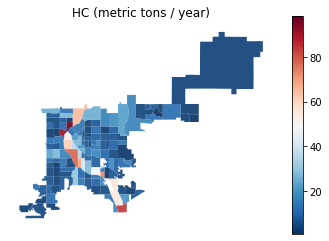

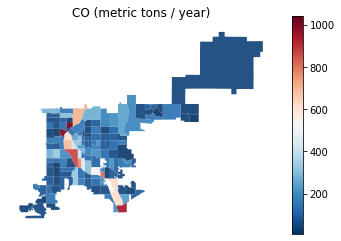

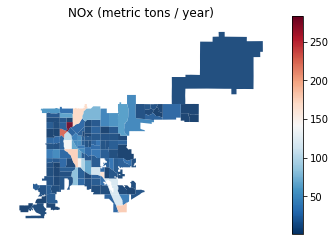

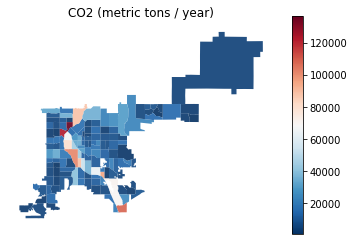

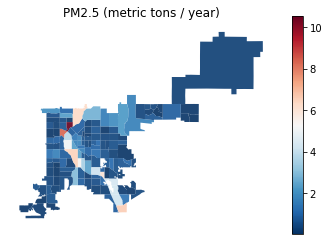

In [30]:
for i, pol in enumerate(pollutants):
#     ax = np.ravel(ax_array)[i]
    combo_denver_persqmi.plot(pol, cmap='RdBu_r', alpha=.9, legend=True)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
    plt.savefig('./figures/colorado/{}_denver_annualtons_persqmi_map.png'.format(pol),dpi=400)

ax.set_facecolor('k')